<a href="https://colab.research.google.com/github/muhammadtarek98/deep-learning-curve-A.I-solutions-internship/blob/main/football_match_objects_detector_TF_API_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3335, done.
remote: Counting objects: 100% (3335/3335), done.
remote: Compressing objects: 100% (2761/2761), done.
remote: Total 3335 (delta 884), reused 1409 (delta 524), pack-reused 0
Receiving objects: 100% (3335/3335), 34.32 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (884/884), done.


In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.8.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [ ]:
!python -m pip install models/research

Processing ./models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 2.2 MB 4.8 MB/s 
     |████████████████████████████████| 23.4 MB 4.8 MB/s 
     |████████████████████████████████| 4.9 MB 11.9 MB/s 
     |████████████████████████████████| 636 kB 4.4 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.0 MB/s 
     |████████████████████████████████| 99 kB 4.9 MB/s 
     |████████████████████████████████| 237 kB 7.1 MB/s 
     |████████████████████████████████| 47.8 MB 34 kB/s 
     

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

In [ ]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10115_jpg.rf.f36264dc0682149e66e790774615cc80.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10116_jpg.rf.2afde043f1bc41f7016f3655512349d9.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10201_jpg.rf.dbf2cf5d7e51c422a44ecf52d7d82b2d.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10348_jpg.rf.aa99c637a9674034d55fdfecfce5038b.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10426_jpg.rf.6b2e2f9c56bd466c42c373c252d568b9.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10438_jpg.rf.39ef200c61eb56e89ae57537578b2617.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10888_jpg.rf.5bb736445448747f3e3ad0ee851b9872.jpg
/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals11218_jpg.rf.43082e986ebf305eb3e5ada5e17fff9c.jpg
/content/drive/MyDrive/f

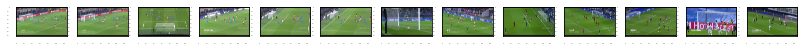

In [ ]:
%matplotlib inline

train_image_dir = '/content/drive/MyDrive/football match actions.v8i.tensorflow/train'
train_images_np = []
dirs=['/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10115_jpg.rf.f36264dc0682149e66e790774615cc80.jpg',
     '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10116_jpg.rf.2afde043f1bc41f7016f3655512349d9.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10201_jpg.rf.dbf2cf5d7e51c422a44ecf52d7d82b2d.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10348_jpg.rf.aa99c637a9674034d55fdfecfce5038b.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10426_jpg.rf.6b2e2f9c56bd466c42c373c252d568b9.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10438_jpg.rf.39ef200c61eb56e89ae57537578b2617.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals10888_jpg.rf.5bb736445448747f3e3ad0ee851b9872.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals11218_jpg.rf.43082e986ebf305eb3e5ada5e17fff9c.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals11735_jpg.rf.5b07a160eb2aa87a6d7f94fcbea3a96f.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals12099_jpg.rf.83b39b4c9ee894b1a88ff72e4bc59795.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals12559_jpg.rf.9408c73c7c9f5b500b22e663b91acf60.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals12815_jpg.rf.f4cd1e0ef6b24ffb4940d56b5731d9cc.jpg',
      '/content/drive/MyDrive/football match actions.v9i.tensorflow/train/goals14028_jpg.rf.1b1129370437f57a9ca43959f3309911.jpg'
      ]
for i in range(len(dirs)):

    # define the path (string) for each image
    image_path = dirs[i]
    #os.path.join(train_image_dir+dirs+'.jpg')
    print(image_path)
    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, len(dirs), idx+1)
    plt.imshow(train_image_np)

plt.show()

In [ ]:
gt_boxes = []

In [ ]:
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
for gt_box in gt_boxes:
  print(gt_box)

[[0.38108333 0.26640625 0.47441667 0.3296875 ]
 [0.39275    0.33203125 0.52108333 0.375     ]
 [0.38941667 0.40625    0.57608333 0.4671875 ]
 [0.32941667 0.47265625 0.56775    0.5984375 ]
 [0.31775    0.68046875 0.46608333 0.7140625 ]
 [0.35775    0.72421875 0.52608333 0.759375  ]
 [0.31108333 0.76875    0.47441667 0.80546875]
 [0.35775    0.80890626 0.49108333 0.85734376]
 [0.51775    0.74875001 0.69441667 0.79562501]
 [0.26275    0.86671876 0.42108333 0.91515626]]
[[0.38441667 0.270625   0.48108333 0.3315625 ]
 [0.39108333 0.34171875 0.52775    0.3784375 ]
 [0.38941667 0.420625   0.56108333 0.53234375]
 [0.31775    0.52765625 0.48108333 0.62609375]
 [0.33108333 0.68703125 0.48608333 0.7284375 ]
 [0.35608333 0.7378125  0.52775    0.7721875 ]
 [0.30441667 0.7675     0.45108333 0.8159375 ]
 [0.51941667 0.76515625 0.69108333 0.8096875 ]
 [0.35775    0.820625   0.50275    0.86203125]
 [0.25108333 0.86281251 0.39941667 0.92843751]]
[[0.20108333 0.14609375 0.34608333 0.2109375 ]
 [0.16275  

In [ ]:
player_class_id = 1
players_class_id=2
ball_class_id=3
referee_class_id=4


category_index = {player_class_id:{'id':player_class_id,'name':'player'},
                  players_class_id:{'id':players_class_id,'name':'players'},
                  ball_class_id:{'id':ball_class_id,'name':'ball'},
                  referee_class_id:{'id':referee_class_id,'name':'referee'}
                  }

num_classes =len(category_index)

In [ ]:
label_id_offset = 1
train_image_tensors = []

gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))

for idx in range(len(dirs)):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx]], dtype=np.int32),dummy_scores, category_index)

plt.show()

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-04-29 04:04:17--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.193.128, 2607:f8b0:400c:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.193.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   200MB/s    in 1.2s    

2022-04-29 04:04:19 (200 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()


### START CODE HERE ###
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path=pipeline_config)

### END CODE HERE ###
# See what configs looks like
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

In [ ]:
model_config = configs['model']
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

In [ ]:
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
model_config

ssd {
  num_classes: 4
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

In [ ]:
detection_model = model_builder.build(model_config=model_config,is_training=True)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


In [ ]:
detection_model

In [ ]:
tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(_base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,

    _box_prediction_head=detection_model._box_predictor._box_prediction_head,)

In [ ]:
from object_detection.protos import box_predictor_pb2

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(feature_extractor=detection_model.feature_extractor,
                                                     box_predictor=tmp_box_predictor_checkpoint)
          
    

In [ ]:
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'
checkpoint =tf.train.Checkpoint(model = detection_model) 
tmp_model_checkpoint.restore(checkpoint_path)

In [ ]:
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))

tmp_prediction_dict = detection_model.predict(tmp_image,tmp_shapes)


tmp_detections = detection_model.postprocess(tmp_prediction_dict,tmp_shapes)

print('Weights restored!')

Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)
batch_size = 4
num_batches = 100
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate,momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)



In [ ]:
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
    ### START CODE HERE (Replace instances of `None` with your code) ###

        # Preprocess the images
        
        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0) 
        true_shape_tensor = preprocessed_image_tensor.shape 

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
    return total_loss

In [ ]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.3262436
